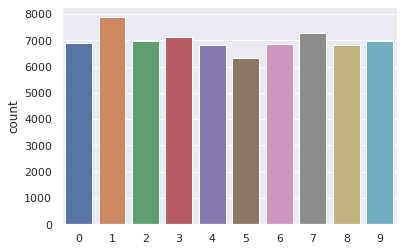

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set()


%matplotlib inline

sns.countplot(label)

* 疑问点
    * 选用什么贝叶斯，，，模型怎么定。。。
    * loss_function是不是得自己建模一下..
    * 输入怎么输入法子...
 
* 思路
    * 先主要看看网上的  ，然后再看看百战怎么处理的= =
    * 能否看下skearn的实现时间和自己的实现时间对比...
    * 需要进行图片增强吗？ 这个到底学习到的是什么？ 如果增强的话会不会有影响...

* 任务要求
   1.对各类图片的分布进行建模,在训练集上利用最大似然方法,估计其分布参数
   2.利用贝叶斯判决对测试集上每张图片进行分类,并验证分类准确率
   3.对实验结果进行分析

* 参考方案
  1.利用PCA进行数据降维
      你确定是用PCA降维吗..
  2.分析分布形式与准确率的关系(以高斯分布为例,可以假设高斯分布各分量之间相互独立与否,分别进行实验并对结果进行分析)
  3.分析降维维度与准确率的关系

2 说明有个接口要给model test(model,data ,feature) :   --> results ( acc , ..? )
                    model(data)
3 说明pca要有个维度的接口

还需要有五折交叉验证？

In [3]:
import numpy as np
import PIL
from PIL import Image

In [4]:
from __future__ import print_function, division
from future.utils import iteritems
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future

import numpy as np
from datetime import datetime
from scipy.stats import norm
from scipy.stats import multivariate_normal as mvn
from numpy import *

# 数据获取

In [5]:
from scipy.io import loadmat
mnist_raw = loadmat("./data/mnist-original.mat")
mnist = {
    "data": mnist_raw["data"].T,
    "label": mnist_raw["label"][0],
    "COL_NAMES": ["label", "data"],
    "DESCR": "mldata.labelorg dataset: mnist-original",
}

In [6]:
%matplotlib
data=mnist["data"]
label=np.array(list(map(int,mnist["label"])))  # change float to int

random.shuffle(data)
random.shuffle(label)

Using matplotlib backend: agg


In [7]:
print(type(data),type(label) )
print( data.shape, label.shape )
print('samples after shuffling is \n data : {} \n label : {} :'.format( data[:10] ,label[:10] )  )

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(70000, 784) (70000,)
samples after shuffling is 
 data : [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] 
 label : [4 5 1 6 3 9 8 2 8 5] :


## 划分测试和训练

In [8]:
Ntrain = len(label)*4 // 5   # 4:1
Xtrain, Ytrain = data[:Ntrain], label[:Ntrain]
Xtest, Ytest = data[Ntrain:], label[Ntrain:]

## 数据基本信息 (before shuffled

In [9]:
mnist["data"].shape # mnist is a dict , not a dataframe
# import pandas as pd
# new_mnist = pd.DataFrame(mnist)
# new_mnist.data.shape

(70000, 784)

In [10]:
mnist["label"].shape

(70000,)

In [11]:
np.unique(mnist["label"])

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

## observe data

In [63]:
# fetch the first 1000 images from the dataset
origin_5_imgs = [] 
for i in range(1000):    
    if label[i] == 5 and len(origin_5_imgs) < 100:        
        origin_5_imgsmgs.append(imgs[i])

def array_to_img(array):
    array=array*255
    new_img=Image.fromarray(array.astype(np.uint8))
    return new_img

# put all images into one picture
def comb_imgs(origin_imgs, col, row, each_width, each_height, new_type):
    new_img = Image.new(new_type, (col* each_width, row* each_height)) 
    for i in range(len(origin_imgs)):
     each_img = array_to_img(np.array(origin_imgs[i]).reshape(each_width, each_width))
     new_img.paste(each_img, ((i % col) * each_width, (i / col) * each_width)) 
    return new_img

'''
效果图
'''

ten_origin_5_imgs=comb_imgs(origin_5_imgs, 10, 10, 2, 28, 'L')
ten_origin_5_imgs.show()

# 降维

## PCA

 这里的mean和std也要自己实现...?
 所以并行的思想是体现在哪里...

### import packgaes

In [71]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from numpy import linalg,mat
from numpy import *

### definition and usage of pca (wrong

#### old version of pca

In [144]:
def pca(data_mat=none, n_components=99999999, var_exp_ratio =0.9 ):  
# def pca(data_mat, top_n_feat=99999999):  
    """    
    主成分分析：    
    输入：矩阵data_mat ，其中该矩阵中存储训练数据，每一行为一条训练数据         保留前n个特征top_n_feat，默认全保留  
    返回：降维后的数据集和原始数据被重构后的矩阵（即降维后反变换回矩阵）  
    """    
    # 获取数据条数和每条的维数  
    
#     import ipdb
#     ipdb.set_trace()
    num_data,dim = data_mat.shape  
#     print(num_data)  # 70000 
#     print(dim)   # 784  

    mean_vals = data_mat.mean(axis=0)  #shape:(784,)  
    mean_removed = data_mat - mean_vals # shape:(100, 784)  

    '''这里rowvar为0，所以不需要转置...或许应该用自带的PCA函数测试一下'''
    cov_mat = np.cov(mean_removed, rowvar=False) # shape：(784, 784)     

    eig_vals, eig_vects = linalg.eig(mat(cov_mat)) # 计算特征值和特征向量，shape分别为（784，）和(784, 784)  
    imagEigValueIndex = nonzero( list(map(lambda x: x.imag ,eig_vals) ) )[0]
#     print("复数特征值的index是：{}".format( nonzero( list(map(lambda x: x.imag ,eig_vals) ) )   )
#     print("复数/特征值的index是：{}".format( nonzero( np.imag(eig_vals)) ) )   
#     eig_vals = np.array(list(map(lambda x: x.real ,eig_vals) ) )
    eig_vals = np.real(eig_vals)
    eig_vects = np.real(eig_vects)
    eig_val_index = argsort(eig_vals)  # 对特征值进行从小到大排序，argsort返回的是索引，即下标 
#     print("特征值最大的index是{}".format(eig_val_index[-100:-50]) )
    
    # variance_explained ration
    tot = sum(eig_vals)
    var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
    cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance
#     print("cum_var_exp is {}",cum_var_exp[1:50])
    plt.plot(range(1,len(cum_var_exp)+1),cum_var_exp )
    plt.xlabel("sorted eigen value number")
    plt.ylabel("cum_var_exp of sorted eigen value （%）")
    
    # 如果指定维数 就用维数
    if( n_components >1000 ):
        whetherAbove90 = np.array(cum_var_exp >= 90, dtype='bool')
#         print("whetherAbove90 is {}".format( whetherAbove90))
        n_components= np.nonzero(whetherAbove90)[0][0] # The first index 
#         print("np.nonzero(whetherAbove90)[0] is {}".format( np.nonzero(whetherAbove90)[0]))
#         print("top_n_feat is {}".format(top_n_feat) ) 
        top_n_cum = cum_var_exp[:n_components+1]
#         print ("Cumsum >90% ，the first {} eigen values contributes ratio is {}%".format(top_n_feat,top_n_cum ) )
        matplotlib.rcParams['font.sans-serif'] = ['Source Han Sans TW', 'sans-serif']
        plt.text(*(n_components+2,90),"({} , 90%)".format(n_components+1))  # top_n_feat+2 to give place for text
        plt.scatter([n_components],[90],s=8,color='red')
    
    eig_val_index = eig_val_index[:-(n_components + 1) : -1] # 最大的前top_n_feat个特征的索引  
    reg_eig_vects = eig_vects[:, eig_val_index]  

    low_d_data_mat = mean_removed * reg_eig_vects # shape: (100, top_n_feat), top_n_feat最大为特征总数  
    recon_mat = (low_d_data_mat * reg_eig_vects.T) + mean_vals # 根据前几个特征向量重构回去的矩阵，shape:(100, 784)

    return low_d_data_mat, recon_mat

In [203]:
??PCA

#### my version of pca

pipeline的话 一些很好的数据特征怎么算出来

In [33]:
#### %pdb on

from sklearn.base import BaseEstimator, TransformerMixin

class myPca(BaseEstimator, TransformerMixin):
    def __init__(self,n_components=40):
        self.n_components=n_components
        self.eig_vals ,self.eig_vects =[ ],[ ]
        self.mean_vals=[]
        self.mean_removed =[] 
#         self.low_d_data_mat=[]   # 实际上fit找到就行  降维应该是后面的transform做的
        
    def fit(self,data_mat,Y=None):
        # get character of training set  
        self.mean_vals = data_mat.mean(axis=0)  #shape:(784,)     # for fit training data 
        self.mean_removed = data_mat - self.mean_vals # shape:(100, 784)  

        cov_mat = np.cov(self.mean_removed, rowvar=False) # shape：(784, 784)     
        print("check cov_mat's shape is {}  ==(748,748)? ".format(cov_mat.shape) )     
        self.eig_vals, self.eig_vects = linalg.eig(mat(cov_mat)) # 计算特征值和特征向量，shape分别为（784，）和(784, 784)  
        '''just for check image value and image vectors'''
        imagEigValueIndex = nonzero( list(map(lambda x: x.imag ,self.eig_vals) ) )[0]
    #     print("复数特征值的index是：{}".format( nonzero( list(map(lambda x: x.imag ,eig_vals) ) )   )
    #     print("复数/特征值的index是：{}".format( nonzero( np.imag(eig_vals)) ) )   
    #     eig_vals = np.array(list(map(lambda x: x.real ,eig_vals) ) )
        '''transform image number to real number/vectors'''
        self.eig_vals = np.real(self.eig_vals)
        self.eig_vects = np.real(self.eig_vects)
        self.eig_val_index = argsort(self.eig_vals)  # 对特征值进行从小到大排序，argsort返回的是索引，即下标 
        
        print("in myPca,n_components is {}".format(self.n_components) ) # 这里给我改成python log   注释和to-do应该怎么区分
        self.eig_val_index = self.eig_val_index[:-(self.n_components + 1) : -1] # 最大的前top_n_feat个特征的索引  
        self.reg_eig_vects = self.eig_vects[:, self.eig_val_index]  
        
#         self.low_d_data_mat = np.array(self.mean_removed * self.reg_eig_vects) # shape: (100, top_n_feat), top_n_feat最大为特征总数  
        return self
        
    #     print("特征值最大的index是{}".format(eig_val_index[-100:-50]) )

        # variance_explained ration
        tot = sum(self.eig_vals)
        var_exp = [(i/tot)*100 for i in sorted(self.eig_vals, reverse=True)] # Individual explained variance
        self.cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance
    
    def transform(self,data_mat):    
        # 这里似乎可以考虑拆出来写一个函数   但是是传值还是传引用比较好呢???
        mean_removed = data_mat - self.mean_vals # shape:(100, 784)  
        
        low_d_data_mat = mean_removed * self.reg_eig_vects # shape: (100, top_n_feat), top_n_feat最大为特征总数  
#         recon_mat = (low_d_data_mat * self.reg_eig_vects.T) + mean_vals # 根据前几个特征向量重构回去的矩阵，shape:(100, 784)
        return np.array(low_d_data_mat)

In [34]:
%pdb on
# %debug 
import pandas as pd
mypca = myPca()   # 
low_d_data_mat = mypca.fit(data,label).transform(data)  # --> low_d_data_mat, recon_mat # 3 只有16%  达到90% 是

pd.DataFrame(low_d_data_mat).head()

Automatic pdb calling has been turned ON
check cov_mat's shape is (784, 784)  ==(748,748)? 
in myPca,n_components is 40


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,295.953144,102.111135,572.288483,-315.550368,328.491939,-797.486917,301.865440,-121.714992,4.862728,-43.975125,...,364.409506,-155.035472,-42.359306,-80.517187,-44.262518,91.156870,302.808804,257.576813,352.328213,83.961848
1,727.996747,-86.074396,442.354521,-428.919317,540.241711,376.945473,-313.275852,-483.718578,84.566344,66.880701,...,-260.545074,68.277923,-42.756755,-179.340968,439.344325,-52.369101,94.473856,193.802920,-120.787262,-84.632039
2,-22.135167,752.521220,498.040359,-740.408693,127.013144,-747.852070,685.717811,-238.137103,-49.536113,306.394966,...,142.473228,-40.160574,-40.663038,-80.165425,-115.774845,-101.621371,-51.668436,-117.570616,-31.736573,-22.744746
3,-175.016212,-443.329943,40.483821,-278.683929,-536.932393,-647.475583,391.089327,-39.228670,-541.569167,103.825015,...,-126.753620,94.894369,48.243730,-87.653832,-32.460570,158.999847,-221.339011,51.834854,126.751713,-22.732123
4,174.667543,141.377902,257.152976,817.033438,-201.696662,541.771946,-27.813836,136.161003,-361.095087,206.023528,...,94.583128,-79.531145,-300.568663,-114.130770,76.616976,139.111873,-78.098837,-282.062718,-41.563835,-50.364178


In [ ]:
mynb =NaiveBayes()
mynb.fit(low_d_data_mat[:Ntrain],label[:Ntrain])
mynb.score(low_d_data_mat[Ntrain:],label[Ntrain:])


> <ipython-input-41-abda7e6e2c32>(21)predict()
     20         ipdb.set_trace()
---> 21         N, D = X.shape
     22         K = len(self.gaussians)  # 这不就是我降维的维度咩

ipdb> n
> <ipython-input-41-abda7e6e2c32>(22)predict()
     21         N, D = X.shape
---> 22         K = len(self.gaussians)  # 这不就是我降维的维度咩
     23         P = np.zeros((N, K))    # 我有

ipdb> p N,D
(14000, 40)
ipdb> n 
> <ipython-input-41-abda7e6e2c32>(23)predict()
     22         K = len(self.gaussians)  # 这不就是我降维的维度咩
---> 23         P = np.zeros((N, K))    # 我有
     24         for c, g in iteritems(self.gaussians):

ipdb> p L
*** NameError: name 'L' is not defined
ipdb> p K
10
ipdb> n
> <ipython-input-41-abda7e6e2c32>(24)predict()
     23         P = np.zeros((N, K))    # 我有
---> 24         for c, g in iteritems(self.gaussians):
     25             mean, var = g['mean'], g['var']

ipdb> n
> <ipython-input-41-abda7e6e2c32>(25)predict()
     24         for c, g in iteritems(self.gaussians):
---> 25             mean, var 

### sklearn version of pca

In [165]:
# using python pca to verify
import sklearn
from sklearn.decomposition import PCA

sklearnPCA = PCA(n_components=100,copy=True, whiten=False)
sklearnPCA.fit(Xtrain)
Xtest= sklearnPCA.fit(Xtrain)
newX=pca.transform(X)

## LDA

# 构建不同的分布model

## using pipeline

In [11]:
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [244]:
'''models'''
sklearnPCA = PCA()
myPCA = myPca()
nb=NaiveBayes()
# pipe = Pipeline(steps=[('sklearnPCA', sklearnPCA ),('myPCA', myPCA ), ('clf', nb)])
pipe = Pipeline(steps=[('myPCA', myPCA ), ('clf', nb)])
# pipe = Pipeline(steps=[('sklearnPCA', sklearnPCA ), ('clf', nb)])
grid_n_components=list(range(40,100,10))

params_grid2 = {  # NaiveBayes不需要参数
'sklearnPCA__n_components': grid_n_components}

params_grid3 = {  # NaiveBayes不需要参数
'myPCA__n_components': grid_n_components}


from sklearn.naive_bayes import GaussianNB
gnb=GaussianNB()
pipe = Pipeline(steps=[('sklearnPCA', sklearnPCA ), ('clf', gnb)])
params_grid = {  # NaiveBayes不需要参数
'sklearnPCA__n_components': grid_n_components
# 'clf': gnb,
}

'''
# this is also ok  名字一样可以写在一起
params_grid = {
'svm__C': [1, 10, 100, 1000],
'svm__kernel': ['linear', 'rbf'],
'svm__gamma': [0.001, 0.0001],
'preprocessing':[myPCA, sklearnPCA],
'preprocessing__n_components': grid_n_components,
}
'''

# grid = GridSearchCV(pipe, param_grid = params_grid)
grid = GridSearchCV(estimator = pipe, param_grid = params_grid)
grid.fit(Xtrain, Ytrain)
# grid.grid_scores_, grid.best_params_, grid.best_score_



/home/daven/.pyenv/versions/tc36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('sklearnPCA',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=None,
                                            random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('clf',
                                        GaussianNB(priors=None,
                                                   var_smoothing=1e-09))],
                                verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'sklearnPCA__n_components': [40, 50, 60, 70, 80, 90]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

## results using sklearnPCA and sklearnGussianNB

In [248]:
Ytrain[1:100]

array([0, 6, 1, 0, 1, 5, 7, 1, 1, 0, 4, 5, 7, 8, 1, 1, 9, 0, 2, 1, 1, 4,
       6, 5, 8, 0, 0, 8, 1, 1, 2, 8, 9, 5, 5, 4, 5, 5, 0, 1, 3, 1, 4, 7,
       0, 8, 2, 4, 0, 6, 8, 8, 2, 5, 9, 1, 7, 1, 7, 3, 3, 9, 2, 7, 5, 1,
       5, 0, 8, 1, 9, 9, 9, 0, 5, 3, 2, 8, 2, 1, 6, 7, 8, 0, 2, 0, 5, 1,
       2, 5, 2, 6, 6, 6, 1, 2, 0, 3, 1])

## debug class of pipeline

In [35]:
from sklearn import svm
from sklearn.datasets import samples_generator
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
import pandas as pd

In [36]:

class Debug(BaseEstimator, TransformerMixin):

    def transform(self, X):
        print('*****************  come into debug class *************')
        print(pd.DataFrame(X).head())
        print(X.shape)
        return X

    def fit(self, X, y=None, **fit_params):
        return self
         
# X, y = samples_generator.make_classification(n_informative=5, n_redundant=0, random_state=42)
# anova_filter = SelectKBest(f_regression, k=5)
# clf = svm.SVC(kernel='linear')
# anova_svm = Pipeline([('anova', anova_filter), ('dbg', Debug()), ('svc', clf)])
# anova_svm.set_params(anova__k=10, svc__C=.1).fit(X, y)

# prediction = anova_svm.predict(X)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

mnb= MultinomialNB()
gnb=GaussianNB()
sklearnPCA = PCA()
pipe = Pipeline(steps=[('sklearnPCA', sklearnPCA ), ('debug',Debug() ),('clf', gnb)])
pipe2 = Pipeline(steps=[('mypca', mypca ), ('debug',Debug() ),('clf', gnb)])
# pipe2 = Pipeline(steps=[('sklearnPCA', mypca() ),('clf', gnb)])
grid_n_components=list(range(40,100,10))
params_grid = {  # NaiveBayes不需要参数
'sklearnPCA__n_components': grid_n_components
# 'clf': gnb,
}
params_grid2 = {  # NaiveBayes不需要参数
'mypca__n_components': grid_n_components
# 'clf': gnb,
}

# grid = GridSearchCV(pipe, param_grid = params_grid)
grid = GridSearchCV(estimator = pipe2, param_grid = params_grid2)
grid.fit(Xtrain, Ytrain)

In [38]:
print('================= grid.cv_results_  =================')
print(grid.cv_results_)
print('================= grid.best_params_  =================')
print(grid.best_params_)
print('================= grid.best_score_  =================')
print(grid.best_score_)

================= grid.cv_results_  =================
{'mean_fit_time': array([1.93813658, 1.8983229 , 1.91097307, 1.97245836, 1.96097827,
       1.95779936]), 'std_fit_time': array([0.08482273, 0.0391215 , 0.05125795, 0.03449764, 0.01727635,
       0.01296013]), 'mean_score_time': array([0.18083541, 0.19115496, 0.19805876, 0.20554304, 0.21608496,
       0.24069103]), 'std_score_time': array([0.00466703, 0.00220046, 0.00350638, 0.00219373, 0.00197603,
       0.00965469]), 'param_mypca__n_components': masked_array(data=[40, 50, 60, 70, 80, 90],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'mypca__n_components': 40}, {'mypca__n_components': 50}, {'mypca__n_components': 60}, {'mypca__n_components': 70}, {'mypca__n_components': 80}, {'mypca__n_components': 90}], 'split0_test_score': array([0.10513631, 0.10406513, 0.100316  , 0.10186921, 0.10513631,
       0.10352954]), 'split1_test_score': array([0.10462313, 0.1

## results using sklearnPCA and myGussianNB

In [229]:
grid.cv_results_

{'mean_fit_time': array([2.22224951, 2.54521155, 3.10633636, 3.2802031 , 2.42937056,
        2.44914381]),
 'std_fit_time': array([0.04046461, 0.02239172, 0.07402178, 0.00650287, 0.10505   ,
        0.02747853]),
 'mean_score_time': array([0.19233918, 0.22424412, 0.26351213, 0.29873681, 0.39650512,
        0.37799597]),
 'std_score_time': array([0.03041385, 0.03613781, 0.04072418, 0.02323294, 0.04189711,
        0.05025253]),
 'param_sklearnPCA__n_components': masked_array(data=[40, 50, 60, 70, 80, 90],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'sklearnPCA__n_components': 40},
  {'sklearnPCA__n_components': 50},
  {'sklearnPCA__n_components': 60},
  {'sklearnPCA__n_components': 70},
  {'sklearnPCA__n_components': 80},
  {'sklearnPCA__n_components': 90}],
 'split0_test_score': array([0.10494455, 0.10387315, 0.10660524, 0.10424814, 0.10285531,
        0.10189104]),
 'split1_test_score': array([0.1014624

In [227]:
grid.best_score_

0.10258928571428572

In [39]:
best_model=grid.best_estimator_
best_model.score(Xtest,Ytest)


*****************  come into debug class *************
           0            1           2           3           4           5   \
0 -894.173102   116.063253   41.290309 -447.325365  119.286661   25.497188   
1 -633.450618   125.168159  169.439494  222.638555  207.786427  499.552553   
2 -292.815278   -47.568312 -597.873733  230.327520  147.573500  303.756733   
3  283.681088  1105.435320  321.388377 -166.461242 -522.107013 -290.170420   
4 -849.925831  -799.531454  187.441655  221.913664   45.989381 -330.541230   

           6           7           8           9   ...          30  \
0  320.996193 -354.407934 -225.744542  346.425143  ...   69.264718   
1   94.282710   45.484552  539.370219 -110.768125  ...   18.704899   
2  408.631878 -102.110806 -478.274476  211.747269  ... -167.448623   
3 -204.200829  324.631911  121.482881  318.879464  ...  144.679197   
4 -305.101119  101.838897 -465.377368 -126.894860  ...  -42.303749   

           31          32          33          34      

0.10685714285714286

#### to be continued

In [ ]:
# # Plot the PCA spectrum
# pca.fit(X_digits)

# fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
# ax0.plot(pca.explained_variance_ratio_, linewidth=2)
# ax0.set_ylabel('PCA explained variance')

# ax0.axvline(search.best_estimator_.named_steps['pca'].n_components,
#             linestyle=':', label='n_components chosen')
# # ？？
# ax0.legend(prop=dict(size=12))

# # For each number of components, find the best classifier results
# results = pd.DataFrame(search.cv_results_)
# components_col = 'param_pca__n_components'
# best_clfs = results.groupby(components_col).apply(
#     lambda g: g.nlargest(1, 'mean_test_score'))

# best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score',
#                legend=False, ax=ax1)
# ax1.set_ylabel('Classification accuracy (val)')
# ax1.set_xlabel('n_components')

# plt.tight_layout()
# plt.show()

## 高斯分布

### 各分量之间相互独立 Naive Bayes

还可以考虑带先验和不带先验

In [ ]:
class NaiveBayes(object):
    def fit(self, X, Y, smoothing=1e-2):
        self.gaussians = dict()
        self.priors = dict()
        labels = set(Y)
        for c in labels:
            current_x = X[Y == c]
            self.gaussians[c] = {
                'mean': current_x.mean(axis=0),
                'var': current_x.var(axis=0) + smoothing,
            }
            self.priors[c] = float(len(Y[Y == c])) / len(Y)

    def score(self, X, Y):
        P = self.predict(X)
        return np.mean(P == Y)

    def predict(self, X):
        import ipdb
        ipdb.set_trace()
        N, D = X.shape
        K = len(self.gaussians)  # 这不就是我降维的维度咩
        P = np.zeros((N, K))    # 我有
        for c, g in iteritems(self.gaussians):
            mean, var = g['mean'], g['var']
            P[:,c] = mvn.logpdf(X, mean=mean, cov=var) + np.log(self.priors[c])
        return np.argmax(P, axis=1)

## test codes 

In [12]:
type(low_d_data_mat)

numpy.ndarray

In [13]:
# %debug
if __name__ == '__main__':
    '''check下是否真的需要降维'''
#     for i in range (2)；
#         if compare : compare =false
#     X, Y = np.array(low_d_data_mat),label if compare 
    X, Y = low_d_data_mat,label
    Ntrain = len(Y)*3 // 4   # 4:3   
    Xtrain, Ytrain = X[:Ntrain], Y[:Ntrain]
    Xtest, Ytest = X[Ntrain:], Y[Ntrain:]

    model = NaiveBayes()
    t0 = datetime.now()
    
#     import ipdb 
#     ipdb.set_trace()
    
    model.fit(Xtrain, Ytrain)
    print("Training time:", (datetime.now() - t0))

    t0 = datetime.now()
    print("Train accuracy:", model.score(Xtrain, Ytrain))
    print("Time to compute train accuracy:", (datetime.now() - t0), "Train size:", len(Ytrain))

    t0 = datetime.now()
    print("Test accuracy:", model.score(Xtest, Ytest))


Training time: 0:00:00.025128
Train accuracy: 0.12180952380952381
Time to compute train accuracy: 0:00:00.306796 Train size: 52500
Test accuracy: 0.10668571428571429


### 各变量之间不相互独立

In [160]:
low_d_data_mat.shape


(70000, 100)

## 均匀分布